#Assignment for Internship Application

In [ ]:
#Importing all the necessary modules

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.utils import to_categorical

from tensorflow.keras.layers import Dense, BatchNormalization, Activation, AlphaDropout
from tensorflow.keras.models import Sequential

In [ ]:
#Code for the LRFinder custom callback - reference at the end
#This callback is used to pick a suitable learning rate without having to iterate

import math
from keras.callbacks import LambdaCallback
import keras.backend as K

class LRFinder:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """

    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if batch > 5 and (math.isnan(loss) or loss > self.best_loss * 4):
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)

    def find(self, x_train, y_train, start_lr, end_lr, batch_size=64, epochs=1, **kw_fit):
        # If x_train contains data for multiple inputs, use length of the first input.
        # Assumption: the first element in the list is single input; NOT a list of inputs.
        N = x_train[0].shape[0] if isinstance(x_train, list) else x_train.shape[0]

        # Compute number of batches and LR multiplier
        num_batches = epochs * N / batch_size
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(num_batches))
        # Save weights into a file
        initial_weights = self.model.get_weights()

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit(x_train, y_train,
                       batch_size=batch_size, epochs=epochs,
                       callbacks=[callback],
                       **kw_fit)

        # Restore the weights to the state before model fitting
        self.model.set_weights(initial_weights)

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def find_generator(self, generator, start_lr, end_lr, epochs=1, steps_per_epoch=None, **kw_fit):
        if steps_per_epoch is None:
            try:
                steps_per_epoch = len(generator)
            except (ValueError, NotImplementedError) as e:
                raise e('`steps_per_epoch=None` is only valid for a'
                        ' generator based on the '
                        '`keras.utils.Sequence`'
                        ' class. Please specify `steps_per_epoch` '
                        'or use the `keras.utils.Sequence` class.')
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(epochs * steps_per_epoch))

        # Save weights into a file
        initial_weights = self.model.get_weights()

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch,
                                                      logs: self.on_batch_end(batch, logs))

        self.model.fit_generator(generator=generator,
                                 epochs=epochs,
                                 steps_per_epoch=steps_per_epoch,
                                 callbacks=[callback],
                                 **kw_fit)

        # Restore the weights to the state before model fitting
        self.model.set_weights(initial_weights)

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5, x_scale='log'):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], self.losses[n_skip_beginning:-n_skip_end])
        plt.xscale(x_scale)
        plt.show()

    def plot_loss_change(self, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.01, 0.01)):
        """
        Plots rate of change of the loss function.
        Parameters:
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        derivatives = self.get_derivatives(sma)[n_skip_beginning:-n_skip_end]
        lrs = self.lrs[n_skip_beginning:-n_skip_end]
        plt.ylabel("rate of loss change")
        plt.xlabel("learning rate (log scale)")
        plt.plot(lrs, derivatives)
        plt.xscale('log')
        plt.ylim(y_lim)
        plt.show()

    def get_derivatives(self, sma):
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivatives.append((self.losses[i] - self.losses[i - sma]) / sma)
        return derivatives

    def get_best_lr(self, sma, n_skip_beginning=10, n_skip_end=5):
        derivatives = self.get_derivatives(sma)
        best_der_idx = np.argmin(derivatives[n_skip_beginning:-n_skip_end])
        return self.lrs[n_skip_beginning:-n_skip_end][best_der_idx]

## **Loading and Visualizing the Data**

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


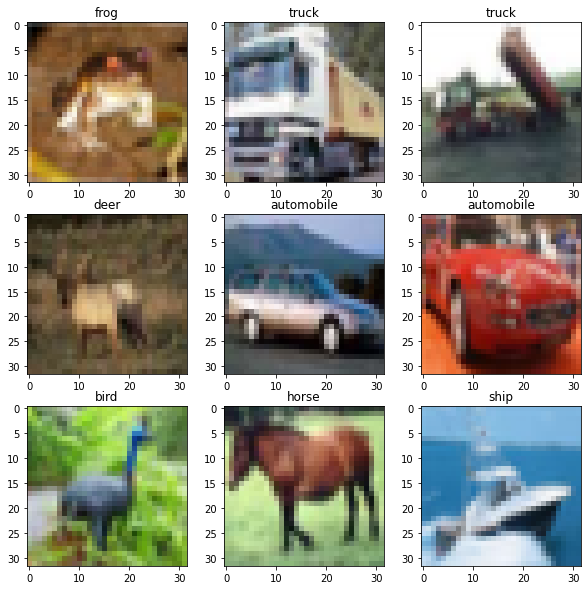

In [ ]:
fig, ax = plt.subplots(3,3,figsize=(10,10))
i=0
for row in ax:
    for col in row:
        col.imshow(x_train[i])
        col.set_title(classes[np.squeeze(y_train[i])])
        i+=1

## **Preprocessing the Data**
We are dividing all the pixel values by 255 (only in the case of self normalizing network, we shall standardize the pixels, i.e., subtract the mean and divide by the standard deviation - to be done later), reshaping the images into a single vectors (since we are using only Dense layers and no convolution layers) and we are converting the labels to categorical values

In [ ]:
x_train = x_train.reshape((x_train.shape[0], 32*32*3))
x_train = x_train.astype('float32') / 255
x_test = x_test.reshape((x_test.shape[0], 32*32*3))
x_test = x_test.astype('float32') / 255

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 3072)
(50000, 10)
(10000, 3072)
(10000, 10)


In [ ]:
#Creating an empty list model_result where we will append the changes in loss and accuracy for each of our different models so that we can 
#compare the learning curves at the very end
model_result=list()

# **Model 1** 
### Creation and fitting of the first model using Nadam optimizer, ELU activation and He Normal initialization

In [ ]:
dense_layers = [Dense(100,activation='elu',kernel_initializer='HeNormal',name='Dense_'+str(i)) for i in range(1,20)]
model = Sequential([Dense(100,activation='elu',kernel_initializer='HeNormal',input_shape=(3072,),name='Dense_0')]\
                   +dense_layers\
                   +[Dense(10,activation='softmax',name='Dense_Output')])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_0 (Dense)              (None, 100)               307300    
_________________________________________________________________
Dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
Dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
Dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
Dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
Dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
Dense_6 (Dense)              (None, 100)               1

### Finding a good learning rate using the LRFinder

Epoch 1/5
391/391 [==============================] - 4s 10ms/step - loss: 2.2801
Epoch 2/5
391/391 [==============================] - 4s 10ms/step - loss: 1.9009
Epoch 3/5
391/391 [==============================] - 4s 10ms/step - loss: 1.9327
Epoch 4/5
391/391 [==============================] - 4s 10ms/step - loss: 1.9697
Epoch 5/5
391/391 [==============================] - 4s 10ms/step - loss: 2.1324


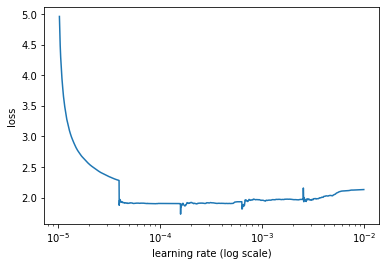

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Nadam(),loss='categorical_crossentropy')
lr_finder = LRFinder(model)
lr_finder.find(x_train, y_train, start_lr=0.00001, end_lr=0.01, batch_size=128, epochs=5)
lr_finder.plot_loss(n_skip_beginning=10, n_skip_end=5)

### Fitting the model with a learning rate of 0.00002


In [ ]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.00002)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=15)
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit(x_train,y_train,batch_size=128,epochs=100,validation_data=(x_test,y_test),callbacks=[earlystop])

Epoch 1/100
391/391 [==============================] - 4s 11ms/step - loss: 2.1725 - accuracy: 0.2406 - val_loss: 1.9155 - val_accuracy: 0.3011
Epoch 2/100
391/391 [==============================] - 4s 10ms/step - loss: 1.8608 - accuracy: 0.3239 - val_loss: 1.8093 - val_accuracy: 0.3379
Epoch 3/100
391/391 [==============================] - 4s 11ms/step - loss: 1.7792 - accuracy: 0.3585 - val_loss: 1.7743 - val_accuracy: 0.3587
Epoch 4/100
391/391 [==============================] - 4s 11ms/step - loss: 1.7232 - accuracy: 0.3787 - val_loss: 1.7048 - val_accuracy: 0.3874
Epoch 5/100
391/391 [==============================] - 4s 11ms/step - loss: 1.6823 - accuracy: 0.3944 - val_loss: 1.6734 - val_accuracy: 0.3960
Epoch 6/100
391/391 [==============================] - 4s 10ms/step - loss: 1.6505 - accuracy: 0.4063 - val_loss: 1.6494 - val_accuracy: 0.4069
Epoch 7/100
391/391 [==============================] - 4s 10ms/step - loss: 1.6216 - accuracy: 0.4180 - val_loss: 1.6479 - val_accuracy:

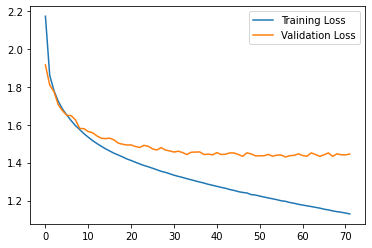

In [ ]:
plt.plot(model.history.history['loss'],label='Training Loss')
plt.plot(model.history.history['val_loss'],label='Validation Loss')
plt.legend()

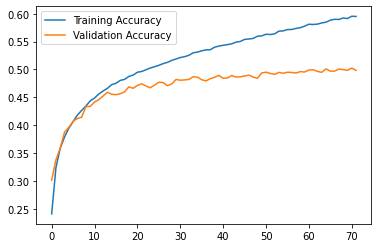

In [ ]:
plt.plot(model.history.history['accuracy'],label='Training Accuracy')
plt.plot(model.history.history['val_accuracy'],label='Validation Accuracy')
plt.legend()

In [ ]:
try:
  model_result[0]=history
except:
  model_result.append(history)

The highest accuracy obtained on the validation set is around **50%**. It took approximately **60 epochs**. Each epoch takes 4.1 seconds.

# **Model 2** 
### Addition of Batch Normalization

A BatchNormalization layer is added after every Dense layer and before the activation function. We need to use a separate Activation layer since the BN layer needs to be applied on the output prior to activation.

In [ ]:
dense_layers = [Dense(100,kernel_initializer='HeNormal',name='Dense_'+str(i)) for i in range(1,20)]
batch_layers=[BatchNormalization(name='Batch_'+str(i)) for i in range(1,20)]
activation_layers=[Activation('elu',name='Activation_'+str(i)) for i in range(1,20)]

all_layers=list()
for i in range(0,len(dense_layers)):
  all_layers.append(dense_layers[i])
  all_layers.append(batch_layers[i])
  all_layers.append(activation_layers[i])

model=Sequential([Dense(100,kernel_initializer='HeNormal',input_shape=(3072,),name='Dense_0')]\
                 +[BatchNormalization(name='Batch_0')]\
                 +[Activation('elu',name='Activation_0')]\
                 +all_layers\
                 +[Dense(10,activation='softmax',name='Dense_Output')])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_0 (Dense)              (None, 100)               307300    
_________________________________________________________________
Batch_0 (BatchNormalization) (None, 100)               400       
_________________________________________________________________
Activation_0 (Activation)    (None, 100)               0         
_________________________________________________________________
Dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
Batch_1 (BatchNormalization) (None, 100)               400       
_________________________________________________________________
Activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
Dense_2 (Dense)              (None, 100)              

### Finding a good learning rate using LRFinder

Epoch 1/5
391/391 [==============================] - 10s 26ms/step - loss: 2.3292
Epoch 2/5
391/391 [==============================] - 10s 26ms/step - loss: 1.8685
Epoch 3/5
391/391 [==============================] - 10s 26ms/step - loss: 1.6658
Epoch 4/5
391/391 [==============================] - 11s 29ms/step - loss: 1.5892
Epoch 5/5
391/391 [==============================] - 11s 29ms/step - loss: 1.6007


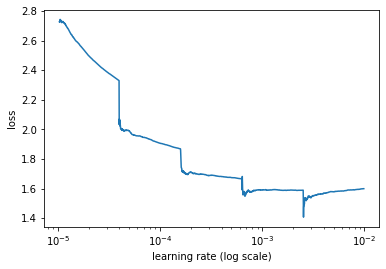

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Nadam(),loss='categorical_crossentropy')
lr_finder = LRFinder(model)
lr_finder.find(x_train, y_train, start_lr=0.00001, end_lr=0.01, batch_size=128, epochs=5)
lr_finder.plot_loss(n_skip_beginning=10, n_skip_end=5)

### Fitting the model with a learning rate of 0.00002

In [ ]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.00002)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit(x_train,y_train,batch_size=128,epochs=100,validation_data=(x_test,y_test),callbacks=[earlystop])

Epoch 1/100
391/391 [==============================] - 12s 31ms/step - loss: 2.2675 - accuracy: 0.2073 - val_loss: 2.0729 - val_accuracy: 0.2656
Epoch 2/100
391/391 [==============================] - 12s 30ms/step - loss: 1.9391 - accuracy: 0.3109 - val_loss: 1.8862 - val_accuracy: 0.3301
Epoch 3/100
391/391 [==============================] - 11s 28ms/step - loss: 1.8255 - accuracy: 0.3515 - val_loss: 1.7937 - val_accuracy: 0.3597
Epoch 4/100
391/391 [==============================] - 11s 27ms/step - loss: 1.7528 - accuracy: 0.3789 - val_loss: 1.7402 - val_accuracy: 0.3810
Epoch 5/100
391/391 [==============================] - 11s 28ms/step - loss: 1.6991 - accuracy: 0.3973 - val_loss: 1.6984 - val_accuracy: 0.3988
Epoch 6/100
391/391 [==============================] - 11s 28ms/step - loss: 1.6548 - accuracy: 0.4098 - val_loss: 1.6627 - val_accuracy: 0.4108
Epoch 7/100
391/391 [==============================] - 11s 27ms/step - loss: 1.6178 - accuracy: 0.4250 - val_loss: 1.6420 - val_ac

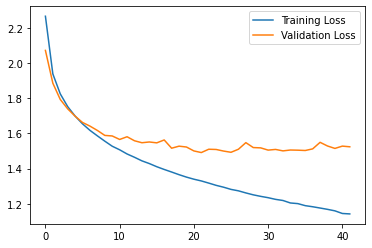

In [ ]:
plt.plot(model.history.history['loss'],label='Training Loss')
plt.plot(model.history.history['val_loss'],label='Validation Loss')
plt.legend()

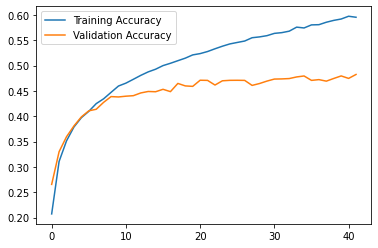

In [ ]:
plt.plot(model.history.history['accuracy'],label='Training Accuracy')
plt.plot(model.history.history['val_accuracy'],label='Validation Accuracy')
plt.legend()

In [ ]:
try:
  model_result[1]=history
except:
  model_result.append(history)

### Comparing Model 1 and 2

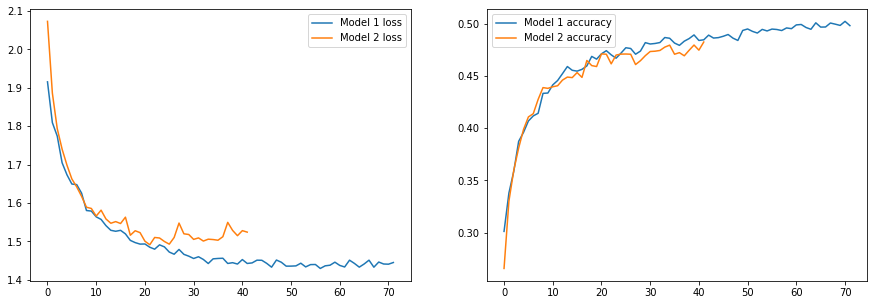

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(15,5))
ax[0].plot(model_result[0].history['val_loss'],label='Model 1 loss')
ax[0].plot(model_result[1].history['val_loss'],label='Model 2 loss')
ax[0].legend()

ax[1].plot(model_result[0].history['val_accuracy'],label='Model 1 accuracy')
ax[1].plot(model_result[1].history['val_accuracy'],label='Model 2 accuracy')
ax[1].legend()

The model converges around as fast as the first model. There is more fluctuation happening in this model. It reaches a maximum accuracy of about **48%**. Although theoretically BN should have made the model converge faster to a better accuracy, it does not happen here.

Also, the second model takes longer per step at **12.31 seconds**.

# **Model 3** 
### Self Normalization using SELU
Note: When using SELU, we must use the Lecun Normal initializer and we must standardize the pixel values.

In [ ]:
#Standardize the pixel values of all the images and reshape to vectors

def normalize_meanstd(a, axis=None): 
    # axis param denotes axes along which mean & std reductions are to be performed
    mean = np.mean(a, axis=axis, keepdims=True)
    std = np.sqrt(((a - mean)**2).mean(axis=axis, keepdims=True))
    return (a - mean) / std

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train_std = normalize_meanstd(x_train, axis=(1,2))
x_test_std = normalize_meanstd(x_test, axis=(1,2))

x_train_std = x_train_std.reshape((x_train_std.shape[0], 32*32*3))
x_test_std = x_test_std.reshape((x_test_std.shape[0], 32*32*3))

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [ ]:
dense_layers = [Dense(100,activation='selu',kernel_initializer='LecunNormal',name='Dense_'+str(i)) for i in range(1,20)]
model = Sequential([Dense(100,activation='selu',kernel_initializer='LecunNormal',input_shape=(3072,),name='Dense_0')]\
                   +dense_layers\
                   +[Dense(10,activation='softmax',name='Dense_Output')])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_0 (Dense)              (None, 100)               307300    
_________________________________________________________________
Dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
Dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
Dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
Dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
Dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
Dense_6 (Dense)              (None, 100)              

### Finding a good learning rate using LRFinder

Epoch 1/5
391/391 [==============================] - 4s 10ms/step - loss: 2.0611
Epoch 2/5
391/391 [==============================] - 4s 11ms/step - loss: 1.9410
Epoch 3/5
391/391 [==============================] - 4s 11ms/step - loss: 1.8464
Epoch 4/5
391/391 [==============================] - 4s 11ms/step - loss: 1.8104
Epoch 5/5
391/391 [==============================] - 4s 11ms/step - loss: 1.8349


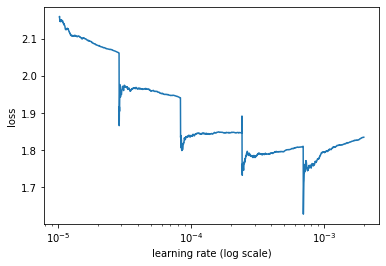

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Nadam(),loss='categorical_crossentropy')
lr_finder = LRFinder(model)
lr_finder.find(x_train_std, y_train, start_lr=0.00001, end_lr=0.002, batch_size=128, epochs=5)
lr_finder.plot_loss(n_skip_beginning=10, n_skip_end=5)

### Fitting the model with a learning rate of 0.0004


In [ ]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.0004)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=15)
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit(x_train_std,y_train,batch_size=128,epochs=100,validation_data=(x_test_std,y_test),callbacks=[earlystop])

Epoch 1/100
391/391 [==============================] - 4s 11ms/step - loss: 1.9859 - accuracy: 0.2950 - val_loss: 1.9049 - val_accuracy: 0.3294
Epoch 2/100
391/391 [==============================] - 4s 10ms/step - loss: 1.7904 - accuracy: 0.3684 - val_loss: 1.7780 - val_accuracy: 0.3747
Epoch 3/100
391/391 [==============================] - 4s 10ms/step - loss: 1.6808 - accuracy: 0.4105 - val_loss: 1.7163 - val_accuracy: 0.4045
Epoch 4/100
391/391 [==============================] - 4s 10ms/step - loss: 1.5903 - accuracy: 0.4423 - val_loss: 1.6698 - val_accuracy: 0.4121
Epoch 5/100
391/391 [==============================] - 4s 10ms/step - loss: 1.5166 - accuracy: 0.4728 - val_loss: 1.6605 - val_accuracy: 0.4274
Epoch 6/100
391/391 [==============================] - 4s 11ms/step - loss: 1.4489 - accuracy: 0.4949 - val_loss: 1.6607 - val_accuracy: 0.4279
Epoch 7/100
391/391 [==============================] - 4s 10ms/step - loss: 1.3955 - accuracy: 0.5173 - val_loss: 1.6624 - val_accuracy:

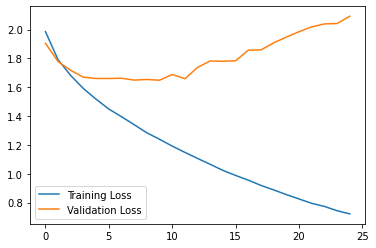

In [ ]:
plt.plot(model.history.history['loss'],label='Training Loss')
plt.plot(model.history.history['val_loss'],label='Validation Loss')
plt.legend()

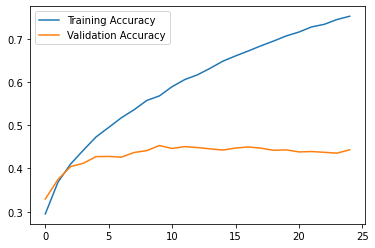

In [ ]:
plt.plot(model.history.history['accuracy'],label='Training Accuracy')
plt.plot(model.history.history['val_accuracy'],label='Validation Accuracy')
plt.legend()

In [ ]:
try:
  model_result[2]=history
except:
  model_result.append(history)

We get a maximum of **45%** accuracy which is worse than both the previous models. But the model appears to converge faster than the previous two. Each step also took 4.10 - 5.10 seconds which is comparable to the first one.

One noticeable aspect is that the model has overfit on the training data, as evident by the high training accuracy. Perhaps adding dropout may help.

# **Model 4** 
### Alpha Dropout and MC Dropout

In [ ]:
dense_layers = [Dense(100,activation='selu',kernel_initializer='LecunNormal',name='Dense_'+str(i)) for i in range(1,20)]

model=Sequential([Dense(100,activation='selu',kernel_initializer='LecunNormal',input_shape=(3072,),name='Dense_0')]\
                 +dense_layers\
                 +[AlphaDropout(0.2)]
                 +[Dense(10,activation='softmax',name='Dense_Output')])

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_0 (Dense)              (None, 100)               307300    
_________________________________________________________________
Dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
Dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
Dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
Dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
Dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
Dense_6 (Dense)              (None, 100)              

### Finding a good learning rate

Epoch 1/5
391/391 [==============================] - 5s 12ms/step - loss: 2.5892
Epoch 2/5
391/391 [==============================] - 5s 12ms/step - loss: 2.2135
Epoch 3/5
391/391 [==============================] - 5s 12ms/step - loss: 1.9275
Epoch 4/5
391/391 [==============================] - 5s 12ms/step - loss: 1.8413
Epoch 5/5
391/391 [==============================] - 5s 12ms/step - loss: 1.9242


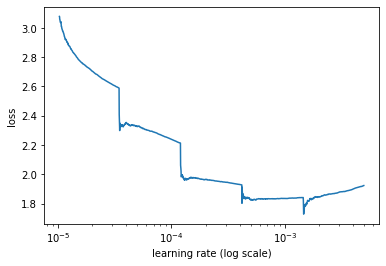

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Nadam(),loss='categorical_crossentropy')
lr_finder = LRFinder(model)
lr_finder.find(x_train_std, y_train, start_lr=0.00001, end_lr=0.005, batch_size=128, epochs=5)
lr_finder.plot_loss(n_skip_beginning=10, n_skip_end=5)

### Fitting the model with a learning rate of 0.0002

In [ ]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.0002)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=15)
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit(x_train_std,y_train,batch_size=128,epochs=100,validation_data=(x_test_std,y_test),callbacks=[earlystop])

Epoch 1/100
391/391 [==============================] - 5s 13ms/step - loss: 2.1481 - accuracy: 0.2516 - val_loss: 1.9211 - val_accuracy: 0.3402
Epoch 2/100
391/391 [==============================] - 5s 12ms/step - loss: 1.8283 - accuracy: 0.3577 - val_loss: 1.8044 - val_accuracy: 0.3859
Epoch 3/100
391/391 [==============================] - 5s 12ms/step - loss: 1.7004 - accuracy: 0.4020 - val_loss: 1.7709 - val_accuracy: 0.4110
Epoch 4/100
391/391 [==============================] - 5s 12ms/step - loss: 1.6082 - accuracy: 0.4389 - val_loss: 1.7501 - val_accuracy: 0.4179
Epoch 5/100
391/391 [==============================] - 5s 12ms/step - loss: 1.5350 - accuracy: 0.4658 - val_loss: 1.8108 - val_accuracy: 0.4308
Epoch 6/100
391/391 [==============================] - 5s 12ms/step - loss: 1.4773 - accuracy: 0.4867 - val_loss: 1.7679 - val_accuracy: 0.4330
Epoch 7/100
391/391 [==============================] - 5s 12ms/step - loss: 1.4177 - accuracy: 0.5072 - val_loss: 1.8407 - val_accuracy:

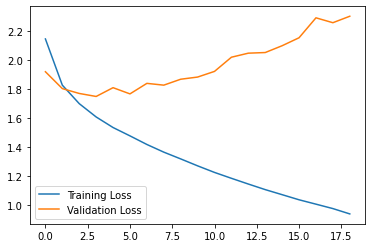

In [ ]:
plt.plot(model.history.history['loss'],label='Training Loss')
plt.plot(model.history.history['val_loss'],label='Validation Loss')
plt.legend()

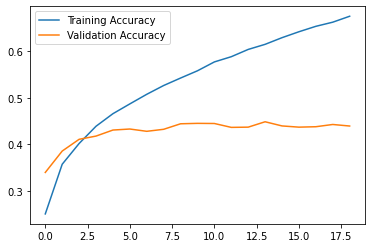

In [ ]:
plt.plot(model.history.history['accuracy'],label='Training Accuracy')
plt.plot(model.history.history['val_accuracy'],label='Validation Accuracy')
plt.legend()

In [ ]:
try:
  model_result[3]=history
except:
  model_result.append(history)

It is quite similar to the model without dropout with a maximum accuracy of about **45%**. Other dropout rates do not affect it too much either. Perhaps adding more dropout layers would help with the overfitting. On the other hand, when I used a dropout layer after every Dense layer, the loss did not seem to decrease

### Using MC Dropout

In [ ]:
class MCAlphaDropout(AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [ ]:
mc_model = Sequential([MCAlphaDropout(layer.rate) if isinstance(layer, AlphaDropout) else layer for layer in model.layers])

In [ ]:
def mc_dropout_predict_probas(mc_model, X, n_samples=10):
    Y_probas = [mc_model.predict(X) for sample in range(n_samples)]
    return np.mean(Y_probas, axis=0)

def mc_dropout_predict_classes(mc_model, X, n_samples=10):
    Y_probas = mc_dropout_predict_probas(mc_model, X, n_samples)
    return np.argmax(Y_probas, axis=1)

In [ ]:
y_pred = mc_dropout_predict_classes(mc_model, x_test_std)
accuracy = np.sum(y_pred==np.argmax(y_test,axis=1))/y_pred.shape[0]
accuracy

0.4427

There is no increase in accuracy by using MC Dropout.

# **Model 5** 
### 1 Cycle Scheduling

In [ ]:
class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [ ]:
dense_layers = [Dense(100,activation='selu',kernel_initializer='LecunNormal',name='Dense_'+str(i)) for i in range(1,20)]

model=Sequential([Dense(100,activation='selu',kernel_initializer='LecunNormal',input_shape=(3072,),name='Dense_0')]\
                 +dense_layers\
                 +[AlphaDropout(0.2)]
                 +[Dense(10,activation='softmax',name='Dense_Output')])

In [ ]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

### Using the max learning rate based on the LRFinder plot of model 4, taking 0.0002

In [ ]:
batch_size=128
n_epochs=100
onecycle = OneCycleScheduler(len(x_train_std) // batch_size * n_epochs, max_rate=0.0002)
history = model.fit(x_train_std, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(x_test_std, y_test),
                    callbacks=[onecycle,earlystop])

Epoch 1/100
391/391 [==============================] - 5s 12ms/step - loss: 2.2695 - accuracy: 0.2188 - val_loss: 1.9878 - val_accuracy: 0.3101
Epoch 2/100
391/391 [==============================] - 4s 11ms/step - loss: 2.0052 - accuracy: 0.2904 - val_loss: 1.9213 - val_accuracy: 0.3389
Epoch 3/100
391/391 [==============================] - 4s 11ms/step - loss: 1.8893 - accuracy: 0.3294 - val_loss: 1.8814 - val_accuracy: 0.3550
Epoch 4/100
391/391 [==============================] - 4s 11ms/step - loss: 1.8093 - accuracy: 0.3598 - val_loss: 1.8456 - val_accuracy: 0.3708
Epoch 5/100
391/391 [==============================] - 4s 11ms/step - loss: 1.7447 - accuracy: 0.3818 - val_loss: 1.8254 - val_accuracy: 0.3840
Epoch 6/100
391/391 [==============================] - 4s 11ms/step - loss: 1.6926 - accuracy: 0.4033 - val_loss: 1.8156 - val_accuracy: 0.3893
Epoch 7/100
391/391 [==============================] - 4s 11ms/step - loss: 1.6433 - accuracy: 0.4212 - val_loss: 1.8061 - val_accuracy:

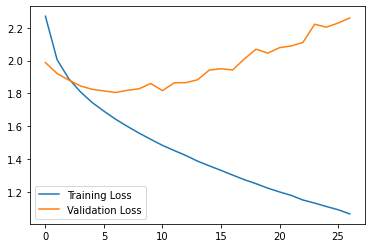

In [ ]:
plt.plot(model.history.history['loss'],label='Training Loss')
plt.plot(model.history.history['val_loss'],label='Validation Loss')
plt.legend()

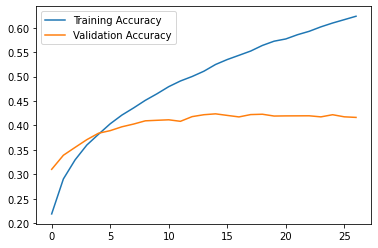

In [ ]:
plt.plot(model.history.history['accuracy'],label='Training Accuracy')
plt.plot(model.history.history['val_accuracy'],label='Validation Accuracy')
plt.legend()

In [ ]:
try:
  model_result[4]=history
except:
  model_result.append(history)

While the model converges quite quickly, the accuracy is lower than all the other models, with the maximum being **42%**. Time per step is comparable to the first model as well at **4.1 seconds**. There appears to be overfitting here as well.

## **Comparing learning curves of all 5 models**

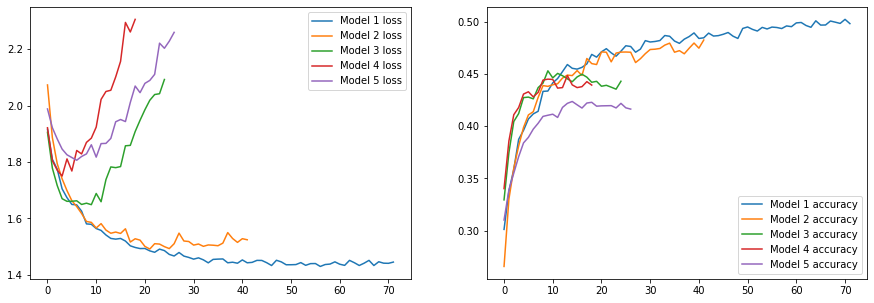

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(15,5))

ax[0].plot(model_result[0].history['val_loss'],label='Model 1 loss')
ax[0].plot(model_result[1].history['val_loss'],label='Model 2 loss')
ax[0].plot(model_result[2].history['val_loss'],label='Model 3 loss')
ax[0].plot(model_result[3].history['val_loss'],label='Model 4 loss')
ax[0].plot(model_result[4].history['val_loss'],label='Model 5 loss')
ax[0].legend()

ax[1].plot(model_result[0].history['val_accuracy'],label='Model 1 accuracy')
ax[1].plot(model_result[1].history['val_accuracy'],label='Model 2 accuracy')
ax[1].plot(model_result[2].history['val_accuracy'],label='Model 3 accuracy')
ax[1].plot(model_result[3].history['val_accuracy'],label='Model 4 accuracy')
ax[1].plot(model_result[4].history['val_accuracy'],label='Model 5 accuracy')
ax[1].legend()

# **References:**

**Cifar10 dataset paper**: 
Learning Multiple Layers of Features from Tiny Images, [Alex Krizhevsky, 2009](https://https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf)

**LRFinder method**: https://github.com/surmenok/keras_lr_finder

**Self-Normalizing Neural Networks**: [Klambauer et al., 2017](https://https://arxiv.org/abs/1706.02515)

**MC Dropout**: [Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning](https://arxiv.org/pdf/1506.02142.pdf)

**1 Cycle Scheduler**: [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/pdf/1506.01186.pdf) 